In [1]:
import pandas as pd
import torch
from torch.nn import Linear
import torch.nn.functional as F
import numpy as np
import torch_geometric
from torch_geometric.data import Data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from torch_geometric.nn.norm import LayerNorm
from pathlib import Path

In [2]:
folder_path = r"C:\Users\msi\Desktop\workspace\042_materials_GNN\Data Sets for ML\Data Sets for ML"
folder = Path(folder_path)

In [3]:
list(folder.glob("*/*/MergedGrainsData*"))

[WindowsPath('C:/Users/msi/Desktop/workspace/042_materials_GNN/Data Sets for ML/Data Sets for ML/V0/125_LS/MergedGrainsData_V0_125_0083_3pct.xlsx'),
 WindowsPath('C:/Users/msi/Desktop/workspace/042_materials_GNN/Data Sets for ML/Data Sets for ML/V0/25_LS/MergedGrainsData_V0_25_0083_3pct.xlsx')]

In [3]:
df = pd.DataFrame()
for idx, p in enumerate(folder.glob("*/*/*/MergedGrainsData*")):
    df_tmp = pd.read_excel(p, header=1)
        
    percent = int(p.parts[-2][:-1])
    tmp = p.parts[-3].split("_")
    temperature = int(tmp[0])
    speed = tmp[1]
    speed = 0 if speed == "LS" else 1
    direction = int(p.parts[-4][1:])

    df_tmp["percent"] = percent
    df_tmp["temperature"] = temperature
    df_tmp["speed"] = speed
    df_tmp["direction"] = direction
    df_tmp["set_num"] = idx
    
    if idx == 0:
        df = df_tmp
    else:
        df = pd.concat([df, df_tmp], axis=0, ignore_index=True)

In [4]:
df.head()

,merged ID,original grain id,phi1,phi,phi2,merged grain area,parent Area,daughter Area,other area,no. of parent grains,...,Rank for Var4,Rank for Var5,Rank for Var6,neighbor grains count,neighbor grain ids,percent,temperature,speed,direction,set_num
0,1,1,17.359108,318.367209,32.276035,20,20,0,0,1,...,1,5,6,3,"18,21,554",3,175,1,0,0
1,2,2,44.741517,358.705821,15.706064,11,11,0,0,1,...,3,1,2,3,"8,9,64",3,175,1,0,0
2,3,3,24.036056,3.543651,14.407177,24,24,0,0,1,...,1,5,6,2,"555,559",3,175,1,0,0
3,4,5,46.505945,358.836343,11.172907,34,34,0,0,1,...,3,1,2,2,"67,581",3,175,1,0,0
4,5,7,29.516996,334.991475,36.742156,23,23,0,0,1,...,2,3,6,2,"64,614",3,175,1,0,0


In [5]:
# csv_path = r"C:\Users\msi\Desktop\workspace\042_materials_GNN\00_data\data\MergedGrainsData.xlsx"
# df = pd.read_excel(csv_path, header=1)

# df.head()

In [6]:
df.columns

Index(['merged ID', 'original grain id', 'phi1', 'phi', 'phi2',
       'merged grain area', 'parent Area', 'daughter Area', 'other area',
       'no. of parent grains', 'no. of daughter grains',
       'daughter grains percent', 'other daughters', 'other daughters area',
       'major axis', 'aspect ratio', 'total boundary length',
       'border boundary length', 'internal boundary length', 'GOS', 'GAM',
       'Schmid SF1', 'Schmid SF2', 'Schmid SF3', 'Schmid SF4', 'Schmid SF5',
       'Schmid SF6', 'Taylor TF1', 'Taylor TF2', 'Taylor TF3', 'Taylor TF4',
       'Taylor TF5', 'Taylor TF6', 'Twin Count for Var1',
       'Twin Count for Var2', 'Twin Count for Var3', 'Twin Count for Var4',
       'Twin Count for Var5', 'Twin Count for Var6', 'Area Twinned for Var1',
       'Area Twinned for Var2', 'Area Twinned for Var3',
       'Area Twinned for Var4', 'Area Twinned for Var5',
       'Area Twinned for Var6', 'Schmid for Var1', 'Schmid for Var2',
       'Schmid for Var3', 'Schmid for Var

In [7]:
ID_COL = 'merged ID'
FEATURE_COLS = [
    'phi1',
    'phi',
    'phi2',
    'merged grain area',
    'major axis',
    'aspect ratio',
    'total boundary length',
    'GOS',
    'GAM',
    'Schmid SF1',
    'Schmid SF2',
    'Schmid SF3',
    'Schmid SF4',
    'Schmid SF5',
    'Schmid SF6',
    'Taylor TF1',
    'Taylor TF2',
    'Taylor TF3',
    'Taylor TF4',
    'Taylor TF5',
    'Taylor TF6',
    'Schmid for Var1',
    'Schmid for Var2',
    'Schmid for Var3',
    'Schmid for Var4',
    'Schmid for Var5',
    'Schmid for Var6',
    'percent',
    'temperature',
    'speed',
    'direction'
]
EDGE_COL = 'neighbor grain ids'

VAGUE_COLS = [
    'major axis',
    'aspect ratio',
    'merged grain area',
    'total boundary length'
]
FEATURE_COLS_INSIDE = [c for c in FEATURE_COLS if c not in VAGUE_COLS]

In [8]:
y = (df["daughter grains percent"] > 0).astype(int).to_numpy()

In [9]:
sum(y)

np.int64(2315)

In [10]:
df[FEATURE_COLS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18632 entries, 0 to 18631
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   phi1                   18632 non-null  float64
 1   phi                    18632 non-null  float64
 2   phi2                   18632 non-null  float64
 3   merged grain area      18632 non-null  int64  
 4   major axis             18632 non-null  float64
 5   aspect ratio           18632 non-null  float64
 6   total boundary length  18632 non-null  int64  
 7   GOS                    18632 non-null  float64
 8   GAM                    18632 non-null  float64
 9   Schmid SF1             18632 non-null  float64
 10  Schmid SF2             18632 non-null  float64
 11  Schmid SF3             18632 non-null  float64
 12  Schmid SF4             18632 non-null  float64
 13  Schmid SF5             18632 non-null  float64
 14  Schmid SF6             18632 non-null  float64
 15  Ta

In [11]:
df[FEATURE_COLS].describe()

,phi1,phi,phi2,merged grain area,major axis,aspect ratio,total boundary length,GOS,GAM,Schmid SF1,...,Schmid for Var1,Schmid for Var2,Schmid for Var3,Schmid for Var4,Schmid for Var5,Schmid for Var6,percent,temperature,speed,direction
count,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,...,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000
mean,29.177421,287.366154,28.844670,326.171962,21.325525,2.046612,88.081151,1.290454,0.883566,0.334870,...,0.191738,0.192017,0.184435,0.184356,0.128514,0.128313,4.965865,248.843388,0.672982,59.447724
std,27.011002,122.233739,28.720843,858.500841,19.782461,1.082041,107.402271,1.213304,0.524056,0.131293,...,0.254918,0.255297,0.264183,0.264245,0.261914,0.261288,1.999762,110.649483,0.469136,42.618784
min,0.001707,0.001946,0.023277,10.000000,3.685321,1.000000,14.000000,0.070525,0.129033,0.000084,...,-0.499920,-0.499964,-0.499985,-0.499805,-0.499997,-0.499496,3.000000,25.000000,0.000000,0.000000
25%,11.967970,314.358557,11.662969,35.000000,9.137906,1.424430,34.000000,0.486118,0.528413,0.242865,...,0.032051,0.031397,0.022117,0.022552,-0.059523,-0.058748,3.000000,175.000000,0.000000,0.000000
50%,25.393093,339.724029,24.324061,103.000000,15.614979,1.751518,58.000000,0.869578,0.764435,0.370747,...,0.261171,0.262455,0.259072,0.259855,0.166495,0.163283,3.000000,225.000000,1.000000,90.000000
75%,45.040712,351.809824,44.103323,288.000000,26.225710,2.283845,100.000000,1.654499,1.083073,0.445004,...,0.401620,0.402146,0.402358,0.401226,0.358763,0.358590,7.000000,325.000000,1.000000,90.000000
max,359.975532,359.998335,359.990164,29114.000000,246.901174,20.813044,2365.000000,13.286989,7.579747,0.499994,...,0.499829,0.499907,0.499923,0.499828,0.499997,0.499994,7.000000,425.000000,1.000000,90.000000


In [12]:
df[EDGE_COL]

0                                                18,21,554
1                                                   8,9,64
2                                                  555,559
3                                                   67,581
4                                                   64,614
                               ...                        
18627                                          532,545,547
18628                          696,698,705,724,728,746,922
18629                  679,682,686,707,711,720,723,763,808
18630    687,692,698,706,715,728,735,739,766,769,770,77...
18631                                                  896
Name: neighbor grain ids, Length: 18632, dtype: object

In [182]:
edges = []
edge_info = df[EDGE_COL].map(lambda x: list(map(int, x.split(","))))
for i, e_list in enumerate(edge_info):
    for e in e_list:
        df_set = df[df["set_num"] == df.iloc[i]["set_num"]]
        node = df_set.index[df_set["merged ID"] == e].to_list()[0]
        
        new = [i, node]
        edges.append(new)
        
edge_index = torch.Tensor(edges).to(dtype=torch.long).t()

In [183]:
df.tail()

,merged ID,original grain id,phi1,phi,phi2,merged grain area,parent Area,daughter Area,other area,no. of parent grains,...,Rank for Var4,Rank for Var5,Rank for Var6,neighbor grains count,neighbor grain ids,percent,temperature,speed,direction,set_num
18627,919,538,39.399561,347.935385,17.936780,52,30,0,22,1,...,3,5,6,3,"532,545,547",7,425,1,90,25
18628,920,746,16.728591,0.639074,36.101943,309,233,76,0,1,...,4,2,1,7,"696,698,705,724,728,746,922",7,425,1,90,25
18629,921,754,41.199993,358.019199,15.227974,772,590,182,0,1,...,1,4,6,9,"679,682,686,707,711,720,723,763,808",7,425,1,90,25
18630,922,803,29.561427,1.504001,18.417803,1600,1068,0,532,1,...,1,5,6,18,"687,692,698,706,715,728,735,739,766,769,770,77...",7,425,1,90,25
18631,923,839,49.563917,336.054992,6.881720,35,21,14,0,1,...,5,6,3,1,896,7,425,1,90,25


In [184]:
np.random.seed(1105)

train_ratio = 0.8

pos_indices = np.where(y == 1)[0]
pos_indices_train, pos_indices_others = train_test_split(
    pos_indices,
    train_size=train_ratio
)
pos_indices_val, pos_indices_test = train_test_split(
    pos_indices_others,
    train_size=0.5
)
assert len(pos_indices) == len(pos_indices_train) + len(pos_indices_val) + len(pos_indices_test)
assert set(pos_indices.tolist()) == set(pos_indices_train.tolist()) | set(pos_indices_val.tolist()) | set(pos_indices_test.tolist())
assert len(set(pos_indices_train.tolist()).intersection(set(pos_indices_val.tolist())).intersection(set(pos_indices_test.tolist()))) == 0

neg_indices = np.where(y == 0)[0]
neg_indices_train, neg_indices_others = train_test_split(
    neg_indices,
    train_size=train_ratio
)
neg_indices_val, neg_indices_test = train_test_split(
    neg_indices_others,
    train_size=0.5
)
assert len(neg_indices) == len(neg_indices_train) + len(neg_indices_val) + len(neg_indices_test)
assert set(neg_indices.tolist()) == set(neg_indices_train.tolist()) | set(neg_indices_val.tolist()) | set(neg_indices_test.tolist())
assert len(set(neg_indices_train.tolist()).intersection(set(neg_indices_val.tolist())).intersection(set(neg_indices_test.tolist()))) == 0

train_indices = pos_indices_train.tolist() + neg_indices_train.tolist()
val_indices = pos_indices_val.tolist() + neg_indices_val.tolist()
test_indices = pos_indices_test.tolist() + neg_indices_test.tolist()

print(f"{len(train_indices) = }")
print(f"{len(val_indices) = }")
print(f"{len(test_indices) = }")

print("split done!")

len(train_indices) = 14905
len(val_indices) = 1863
len(test_indices) = 1864
split done!


In [185]:
tmp_train_mask = np.zeros_like(y)
for i in train_indices:
    tmp_train_mask[i-1] = 1
train_mask = torch.Tensor(tmp_train_mask).to(dtype=bool)

tmp_val_mask = np.zeros_like(y)
for i in val_indices:
    tmp_val_mask[i-1] = 1
val_mask = torch.Tensor(tmp_val_mask).to(dtype=bool)

tmp_test_mask = np.zeros_like(y)
for i in test_indices:
    tmp_test_mask[i-1] = 1
test_mask = torch.Tensor(tmp_test_mask).to(dtype=bool)

assert (train_mask.to(dtype=torch.int16) + val_mask.to(dtype=torch.int16) + test_mask.to(dtype=torch.int16) == 1).all()

In [186]:
X_train = df.loc[train_mask.numpy(), FEATURE_COLS]
X_val = df.loc[val_mask.numpy(), FEATURE_COLS]
X_test = df.loc[test_mask.numpy(), FEATURE_COLS]
y_train = y[train_mask.numpy()]
y_val = y[val_mask.numpy()]
y_test = y[test_mask.numpy()]

print(f"{X_train.shape = } / {X_val.shape} / {X_test.shape}")
print(f"{y_train.shape = } / {y_val.shape} / {y_test.shape}")

X_train.shape = (14905, 31) / (1863, 31) / (1864, 31)
y_train.shape = (14905,) / (1863,) / (1864,)


In [187]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

In [188]:
X = np.zeros_like(df[FEATURE_COLS])
X[train_mask.numpy(), :] = X_train_norm
X[val_mask.numpy(), :] = X_val_norm
X[test_mask.numpy(), :] = X_test_norm

In [189]:
data = Data(
    x=torch.Tensor(X),
    y=torch.Tensor(y),
    edge_index=edge_index,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
)

In [190]:
data

Data(x=[18632, 31], edge_index=[2, 100526], y=[18632], train_mask=[18632], val_mask=[18632], test_mask=[18632])

In [191]:
pd.DataFrame(X, columns=FEATURE_COLS).describe()

,phi1,phi,phi2,merged grain area,major axis,aspect ratio,total boundary length,GOS,GAM,Schmid SF1,...,Schmid for Var1,Schmid for Var2,Schmid for Var3,Schmid for Var4,Schmid for Var5,Schmid for Var6,percent,temperature,speed,direction
count,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,...,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000
mean,0.005253,-0.002108,-0.002646,0.000922,0.000699,0.009177,0.000772,-0.003860,-0.001010,0.002904,...,-0.002074,-0.001605,0.002577,0.003200,0.001848,0.000767,-0.004656,-0.005074,-0.004183,0.002860
std,1.029009,1.001997,0.983180,0.998951,0.996826,1.034095,1.005302,0.991226,1.003679,1.001431,...,1.001183,1.001628,0.996463,0.996625,0.997610,0.997171,0.999958,1.000387,1.001579,0.999062
min,-1.106222,-2.357742,-0.989269,-0.366975,-0.888180,-0.991059,-0.692640,-1.000499,-1.446102,-2.550663,...,-2.718538,-2.716517,-2.578966,-2.577176,-2.392106,-2.395185,-0.987664,-2.028852,-1.440961,-1.390703
25%,-0.650357,0.219159,-0.590815,-0.337885,-0.613427,-0.585436,-0.505437,-0.660974,-0.681204,-0.698859,...,-0.629238,-0.631779,-0.609665,-0.607061,-0.714373,-0.713128,-0.987664,-0.672695,-1.440961,-1.390703
50%,-0.138914,0.427090,-0.157397,-0.258760,-0.287052,-0.272842,-0.280793,-0.347701,-0.229171,0.276554,...,0.270623,0.274750,0.284098,0.287948,0.146513,0.134224,-0.987664,-0.220643,0.693982,0.719061
75%,0.609580,0.526162,0.519692,-0.043495,0.247617,0.235897,0.112334,0.293551,0.381088,0.842948,...,0.822232,0.822813,0.824554,0.821143,0.878850,0.879588,1.012490,0.683462,0.693982,0.719061
max,12.607311,0.593286,11.333225,33.498406,11.367319,17.944056,21.313096,9.796882,12.823600,1.262377,...,1.207947,1.206367,1.192558,1.193031,1.416798,1.419239,1.012490,1.587566,0.693982,0.719061


In [192]:
# from torch_geometric.datasets import Planetoid
# from torch_geometric.transforms import NormalizeFeatures

# dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]

In [193]:
rf_model = RandomForestClassifier(
    n_estimators=5,
    max_depth=50,
    random_state=1105
)

rf_model.fit(X_train_norm, y[train_mask])
y_pred = rf_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


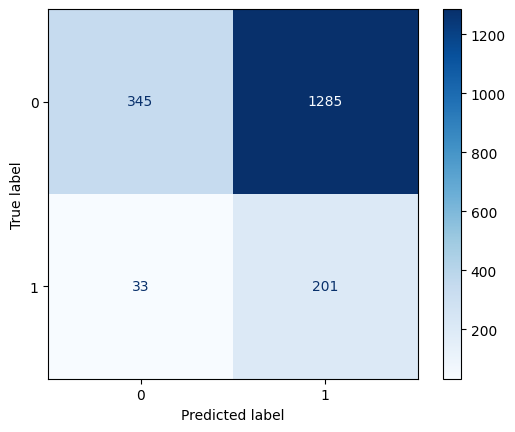

Accuracy: 0.2929
Precision: 0.1353
Recall: 0.8590
f1 score: 0.2337


In [194]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [195]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    random_state=1105
)

lr_model.fit(X_train_norm, y[train_mask])
y_pred = lr_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


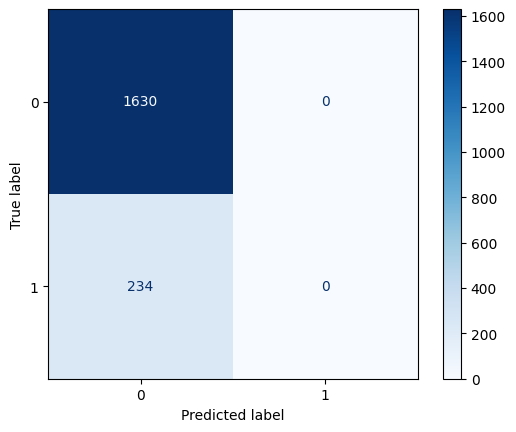

Accuracy: 0.8745
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [196]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [197]:
from sklearn.svm import LinearSVC

class_weight = {
    0: 1.0,
    1: 4.0
}
svc_model = LinearSVC(
    class_weight=class_weight,
    random_state=1105
)

svc_model.fit(X_train_norm, y[train_mask])
y_pred = svc_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


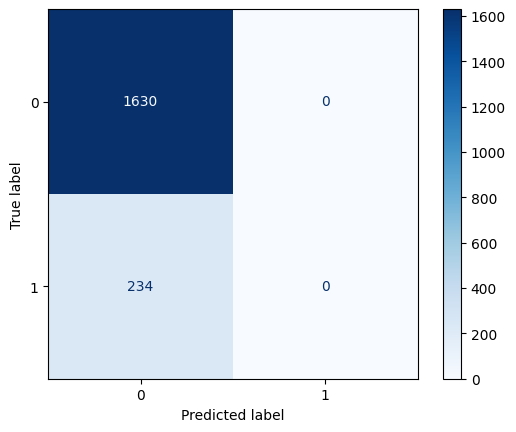

Accuracy: 0.8745
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [198]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [199]:
def count_parameters(params):
    num = sum(p.numel() for p in params if p.requires_grad)
    print(f"{num:,}")
    return num

In [204]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels * 2)
        self.lin3 = Linear(hidden_channels * 2, hidden_channels * 4)
        self.lin4 = Linear(hidden_channels * 4, hidden_channels * 8)
        self.lin5 = Linear(hidden_channels * 8, hidden_channels * 4)
        self.lin6 = Linear(hidden_channels * 4, hidden_channels * 2)
        self.lin7 = Linear(hidden_channels * 2, 1)
        self.norm1 = torch.nn.LayerNorm(hidden_channels)
        self.norm2 = torch.nn.LayerNorm(hidden_channels * 2)
        self.norm3 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm4 = torch.nn.LayerNorm(hidden_channels * 8)
        self.norm5 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm6 = torch.nn.LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin7(x)
        # x = self.log_softmax(x)
        # x = x.squeeze()
        return x
    
model = MLP(hidden_channels=64)
print(f"MLP model number of params: {count_parameters(model.parameters()):,}")

342,017
MLP model number of params: 342,017


In [205]:
weight = torch.Tensor([1.0, 2.5])
criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    X_tmp = data.x[data.train_mask]
    y_tmp = data.y[data.train_mask]
    preds = model(X_tmp).squeeze()  # Perform a single forward pass.
    loss = criterion(preds, y_tmp)  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_X_tmp = data.x[data.val_mask]
        v_y_tmp = data.y[data.val_mask]
        v_preds = model(v_X_tmp).squeeze()
        v_loss = criterion(v_preds, v_y_tmp)
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.8189 / Val_loss: 0.3856
Epoch: 002, Train_loss: 0.5579 / Val_loss: 0.3687
Epoch: 003, Train_loss: 0.4481 / Val_loss: 0.3799
Epoch: 004, Train_loss: 0.4027 / Val_loss: 0.3895
Epoch: 005, Train_loss: 0.3922 / Val_loss: 0.3960
Epoch: 006, Train_loss: 0.3897 / Val_loss: 0.3999
Epoch: 007, Train_loss: 0.3932 / Val_loss: 0.4015
Epoch: 008, Train_loss: 0.3914 / Val_loss: 0.4015
Epoch: 009, Train_loss: 0.3973 / Val_loss: 0.4000
Epoch: 010, Train_loss: 0.3964 / Val_loss: 0.3973
Epoch: 011, Train_loss: 0.3963 / Val_loss: 0.3938
Epoch: 012, Train_loss: 0.3946 / Val_loss: 0.3896
Epoch: 013, Train_loss: 0.3938 / Val_loss: 0.3852
Epoch: 014, Train_loss: 0.3946 / Val_loss: 0.3806
Epoch: 015, Train_loss: 0.3924 / Val_loss: 0.3762
Epoch: 016, Train_loss: 0.3881 / Val_loss: 0.3723
Epoch: 017, Train_loss: 0.3855 / Val_loss: 0.3690
Epoch: 018, Train_loss: 0.3852 / Val_loss: 0.3664
Epoch: 019, Train_loss: 0.3853 / Val_loss: 0.3645
Epoch: 020, Train_loss: 0.3851 / Val_loss: 0.3634


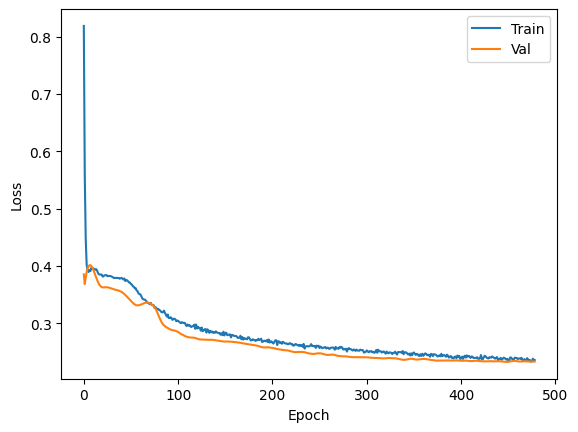

In [206]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

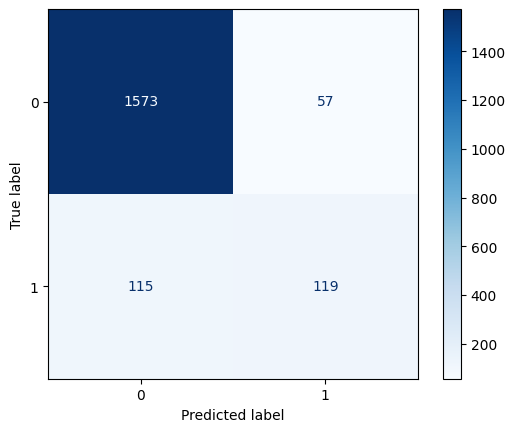

Accuracy: 0.9077
Precision: 0.6761
Recall: 0.5085
f1 score: 0.5805


In [207]:
model.eval()
X_tmp_test = data.x[data.test_mask]
y_tmp_test = data.y[data.test_mask]
with torch.no_grad():
    out = model(X_tmp_test)
# pred = out.argmax(dim=1)  # Use the class with highest probability.
pred = F.sigmoid(out).round()

cm = confusion_matrix(y_tmp_test, pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"Precision: {precision_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"Recall: {recall_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"f1 score: {f1_score(y_tmp_test.numpy(), pred.numpy()):.4f}")

In [208]:
import shap

shap.initjs()

shap_data = data.x[data.train_mask]
background = shap_data[np.random.choice(shap_data.shape[0], 2000, replace=False)]
shap_test = data.x[data.test_mask][np.random.choice(data.x[data.test_mask].shape[0], 200, replace=False)]

explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(shap_test, check_additivity=False)

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f'unrecognized nn.Module: {module_type}')


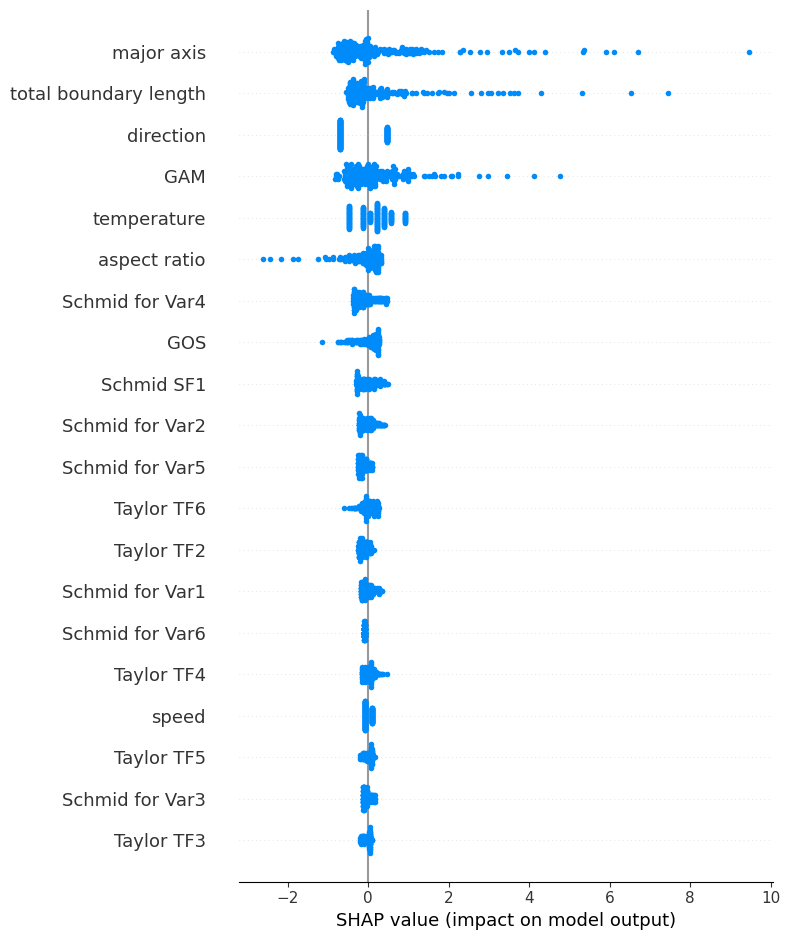

In [210]:
# exp = shap.Explanation(shap_values.squeeze(), feature_names=FEATURE_COLS)
# shap.plots.beeswarm(exp, color=['red', 'blue'])

shap.summary_plot(shap_values.squeeze(), feature_names=FEATURE_COLS)

In [213]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GCNConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GCNConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        x = x.squeeze()
        # x = self.log_softmax(x)
        return x

model = GCN(hidden_channels=64)
print(f"GCN model number of params: {count_parameters(model.parameters()):,}")

342,017
GCN model number of params: 342,017


In [214]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.4961 / Val_loss: 0.4870
Epoch: 002, Train_loss: 0.4261 / Val_loss: 0.4238
Epoch: 003, Train_loss: 0.4178 / Val_loss: 0.4223
Epoch: 004, Train_loss: 0.4107 / Val_loss: 0.4166
Epoch: 005, Train_loss: 0.4037 / Val_loss: 0.4128
Epoch: 006, Train_loss: 0.3930 / Val_loss: 0.3978
Epoch: 007, Train_loss: 0.3894 / Val_loss: 0.3914
Epoch: 008, Train_loss: 0.3889 / Val_loss: 0.3883
Epoch: 009, Train_loss: 0.3860 / Val_loss: 0.3839
Epoch: 010, Train_loss: 0.3882 / Val_loss: 0.3877
Epoch: 011, Train_loss: 0.3859 / Val_loss: 0.3848
Epoch: 012, Train_loss: 0.3868 / Val_loss: 0.3873
Epoch: 013, Train_loss: 0.3860 / Val_loss: 0.3786
Epoch: 014, Train_loss: 0.3823 / Val_loss: 0.3785
Epoch: 015, Train_loss: 0.3798 / Val_loss: 0.3817
Epoch: 016, Train_loss: 0.3789 / Val_loss: 0.3757
Epoch: 017, Train_loss: 0.3801 / Val_loss: 0.3863
Epoch: 018, Train_loss: 0.3792 / Val_loss: 0.3786
Epoch: 019, Train_loss: 0.3815 / Val_loss: 0.3829
Epoch: 020, Train_loss: 0.3791 / Val_loss: 0.3799


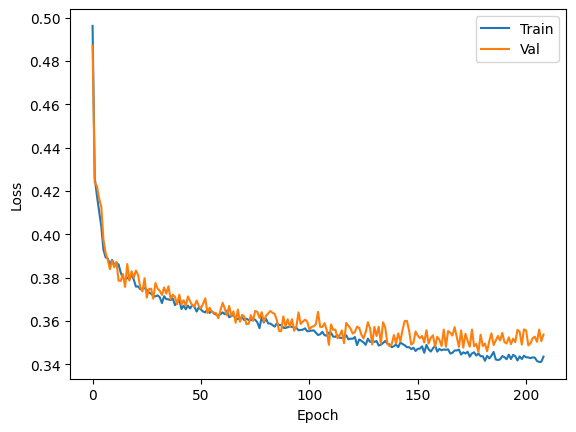

In [215]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [216]:
model.eval()
out = model(data.x, data.edge_index)
# pred = out.argmax(dim=1)  # Use the class with highest probability.
with torch.no_grad():
    pred = F.sigmoid(out).round()

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

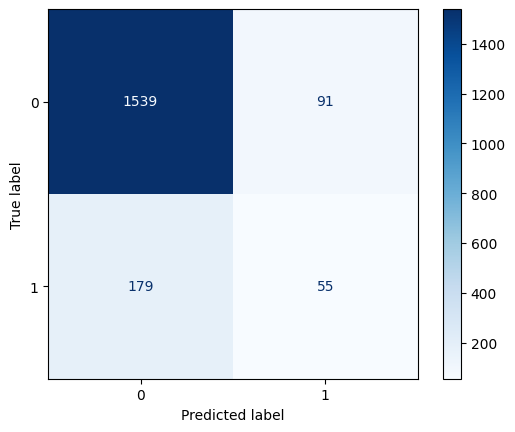

Accuracy: 0.8552
Precision: 0.3767
Recall: 0.2350
f1 score: 0.2895


In [217]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [218]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GATConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GATConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GATConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GATConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        # x = self.log_softmax(x)
        x = x.squeeze()
        return x


model = GAT(hidden_channels=64)
print(f"GAT model number of params: {count_parameters(model.parameters()):,}")

344,707
GAT model number of params: 344,707


In [219]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight) # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.5593 / Val_loss: 0.5526
Epoch: 002, Train_loss: 0.4577 / Val_loss: 0.4320
Epoch: 003, Train_loss: 0.4623 / Val_loss: 0.4380
Epoch: 004, Train_loss: 0.4347 / Val_loss: 0.4210
Epoch: 005, Train_loss: 0.3976 / Val_loss: 0.3998
Epoch: 006, Train_loss: 0.3827 / Val_loss: 0.3795
Epoch: 007, Train_loss: 0.3734 / Val_loss: 0.3726
Epoch: 008, Train_loss: 0.3863 / Val_loss: 0.3892
Epoch: 009, Train_loss: 0.3771 / Val_loss: 0.3788
Epoch: 010, Train_loss: 0.3812 / Val_loss: 0.3865
Epoch: 011, Train_loss: 0.3727 / Val_loss: 0.3693
Epoch: 012, Train_loss: 0.3618 / Val_loss: 0.3613
Epoch: 013, Train_loss: 0.3634 / Val_loss: 0.3580
Epoch: 014, Train_loss: 0.3582 / Val_loss: 0.3578
Epoch: 015, Train_loss: 0.3588 / Val_loss: 0.3514
Epoch: 016, Train_loss: 0.3592 / Val_loss: 0.3481
Epoch: 017, Train_loss: 0.3576 / Val_loss: 0.3541
Epoch: 018, Train_loss: 0.3549 / Val_loss: 0.3547
Epoch: 019, Train_loss: 0.3560 / Val_loss: 0.3541
Epoch: 020, Train_loss: 0.3522 / Val_loss: 0.3453


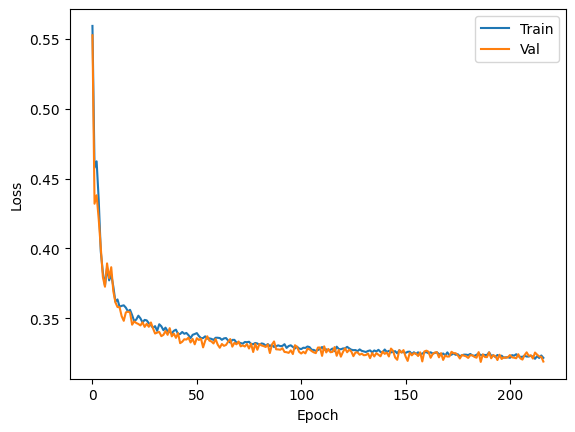

In [220]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [221]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = F.sigmoid(out).round()
# pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

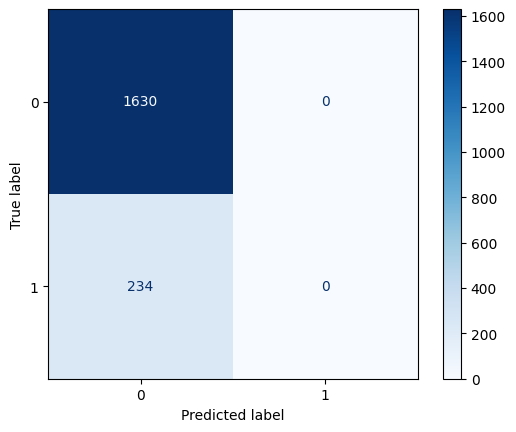

Accuracy: 0.8745
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [222]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

#### 외곽선에 걸친 샘플 제거

In [13]:
BORDER_COL = 'border boundary length'
df_inside = df[df[BORDER_COL] == 0]
df_inside = df_inside.reset_index(drop=True)

In [14]:
df_inside.shape

(16043, 64)

In [21]:
edges_2 = []
edge_info_2 = df_inside[EDGE_COL].map(lambda x: list(map(int, x.split(","))))
for i, e_list in enumerate(edge_info_2):
    df_set = df_inside[df_inside["set_num"] == df_inside.iloc[i]["set_num"]]
    indices_included = df_set["merged ID"].tolist()
    for e in e_list:
        if e in indices_included:
            idx = df_set.index[df_set["merged ID"] == e].tolist()[0]
            new = [i, idx]
            edges_2.append(new)
        
edge_index_2 = torch.Tensor(edges_2).to(dtype=torch.long).t()

In [53]:
edge_index_2[:, edge_index_2[0] == 15234]

tensor([], size=(2, 0), dtype=torch.int64)

In [41]:
edge_index_2[0, 74160]

tensor(15233)

In [42]:
df_inside[df_inside["set_num"] == df_inside["set_num"].iloc[-1]][:50]

,merged ID,original grain id,phi1,phi,phi2,merged grain area,parent Area,daughter Area,other area,no. of parent grains,...,Rank for Var4,Rank for Var5,Rank for Var6,neighbor grains count,neighbor grain ids,percent,temperature,speed,direction,set_num
15233,9,9,10.134939,7.609234,51.019148,26,26,0,0,1,...,4,3,6,3,"2,46,59",7,425,1,90,25
15234,10,10,52.390215,355.674708,2.241037,31,31,0,0,1,...,1,4,6,4,"1,4,12,44",7,425,1,90,25
15235,11,11,8.105772,8.579832,53.733370,20,20,0,0,1,...,2,6,5,3,"2,14,59",7,425,1,90,25
15236,13,13,15.607356,323.174189,40.657522,21,21,0,0,1,...,4,6,5,5,"8,12,20,22,36",7,425,1,90,25
15237,17,17,54.604796,354.143851,9.170345,21,21,0,0,1,...,1,4,6,3,"16,28,42",7,425,1,90,25
15238,18,18,24.977943,311.062411,16.112529,15,15,0,0,1,...,6,3,4,1,89,7,425,1,90,25
15239,22,22,30.436445,355.589853,36.563338,66,66,0,0,1,...,6,2,1,5,"13,20,27,36,66",7,425,1,90,25
15240,23,23,15.222485,341.649022,51.687015,72,72,0,0,1,...,2,6,5,4,"16,25,28,56",7,425,1,90,25
15241,24,24,46.440236,356.917186,6.967073,12,12,0,0,1,...,1,5,6,2,"32,44",7,425,1,90,25
15242,25,25,14.047018,314.795996,32.222028,293,293,0,0,1,...,4,6,5,6,"6,16,23,56,80,89",7,425,1,90,25


In [50]:
d = pd.DataFrame(edge_index_2.t())

In [51]:
sum(d.apply(lambda x: set(x), axis=1).value_counts() != 2)

0

In [55]:
y = (df_inside["daughter grains percent"] > 0).map(int).to_numpy()

In [61]:
np.random.seed(1105)

train_ratio = 0.7

pos_indices = np.where(y == 1)[0]
pos_indices_train, pos_indices_others = train_test_split(
    pos_indices,
    train_size=train_ratio
)
pos_indices_val, pos_indices_test = train_test_split(
    pos_indices_others,
    train_size=0.5
)
assert len(pos_indices) == len(pos_indices_train) + len(pos_indices_val) + len(pos_indices_test)
assert set(pos_indices.tolist()) == set(pos_indices_train.tolist()) | set(pos_indices_val.tolist()) | set(pos_indices_test.tolist())
assert len(set(pos_indices_train.tolist()).intersection(set(pos_indices_val.tolist())).intersection(set(pos_indices_test.tolist()))) == 0

neg_indices = np.where(y == 0)[0]
neg_indices_train, neg_indices_others = train_test_split(
    neg_indices,
    train_size=train_ratio
)
neg_indices_val, neg_indices_test = train_test_split(
    neg_indices_others,
    train_size=0.5
)
assert len(neg_indices) == len(neg_indices_train) + len(neg_indices_val) + len(neg_indices_test)
assert set(neg_indices.tolist()) == set(neg_indices_train.tolist()) | set(neg_indices_val.tolist()) | set(neg_indices_test.tolist())
assert len(set(neg_indices_train.tolist()).intersection(set(neg_indices_val.tolist())).intersection(set(neg_indices_test.tolist()))) == 0

train_indices = pos_indices_train.tolist() + neg_indices_train.tolist()
val_indices = pos_indices_val.tolist() + neg_indices_val.tolist()
test_indices = pos_indices_test.tolist() + neg_indices_test.tolist()

print(f"{len(train_indices) = }")
print(f"{len(val_indices) = }")
print(f"{len(test_indices) = }")

print("split done!")

len(train_indices) = 11229
len(val_indices) = 2407
len(test_indices) = 2407
split done!


In [62]:
tmp_train_mask = np.zeros_like(y)
for i in train_indices:
    tmp_train_mask[i-1] = 1
train_mask = torch.Tensor(tmp_train_mask).to(dtype=bool)

tmp_val_mask = np.zeros_like(y)
for i in val_indices:
    tmp_val_mask[i-1] = 1
val_mask = torch.Tensor(tmp_val_mask).to(dtype=bool)

tmp_test_mask = np.zeros_like(y)
for i in test_indices:
    tmp_test_mask[i-1] = 1
test_mask = torch.Tensor(tmp_test_mask).to(dtype=bool)

assert (train_mask.to(dtype=torch.int16) + val_mask.to(dtype=torch.int16) + test_mask.to(dtype=torch.int16) == 1).all()

In [63]:
X_train = df_inside.loc[train_mask.numpy(), FEATURE_COLS]
X_val = df_inside.loc[val_mask.numpy(), FEATURE_COLS]
X_test = df_inside.loc[test_mask.numpy(), FEATURE_COLS]
y_train = y[train_mask.numpy()]
y_val = y[val_mask.numpy()]
y_test = y[test_mask.numpy()]

print(f"{X_train.shape = } / {X_val.shape} / {X_test.shape}")
print(f"{y_train.shape = } / {y_val.shape} / {y_test.shape}")

X_train.shape = (11229, 31) / (2407, 31) / (2407, 31)
y_train.shape = (11229,) / (2407,) / (2407,)


In [64]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

In [65]:
X = np.zeros_like(df_inside[FEATURE_COLS])
X[train_mask.numpy(), :] = X_train_norm
X[val_mask.numpy(), :] = X_val_norm
X[test_mask.numpy(), :] = X_test_norm

In [66]:
data = Data(
    x=torch.Tensor(X),
    y=torch.Tensor(y),
    edge_index=edge_index_2,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
)

In [67]:
data

Data(x=[16043, 31], edge_index=[2, 78150], y=[16043], train_mask=[16043], val_mask=[16043], test_mask=[16043])

In [68]:
pd.DataFrame(X, columns=FEATURE_COLS).describe()

,phi1,phi,phi2,merged grain area,major axis,aspect ratio,total boundary length,GOS,GAM,Schmid SF1,...,Schmid for Var1,Schmid for Var2,Schmid for Var3,Schmid for Var4,Schmid for Var5,Schmid for Var6,percent,temperature,speed,direction
count,16043.000000,16043.000000,16043.000000,16043.000000,16043.000000,16043.000000,16043.000000,16043.000000,16043.000000,16043.000000,...,16043.000000,16043.000000,16043.000000,16043.000000,16043.000000,16043.000000,16043.000000,16043.000000,16043.000000,16043.000000
mean,0.005118,-0.001282,-0.003046,0.006106,0.001244,-0.005727,0.003218,-0.000560,-0.005918,0.002091,...,-0.003193,-0.003104,-0.005603,-0.005278,-0.003631,-0.004046,-0.000684,0.005320,0.002056,-0.003219
std,1.019592,1.002493,0.986684,1.078679,1.012464,1.002124,1.016186,1.006373,1.000795,1.001523,...,0.999148,0.999231,1.001392,1.001178,0.998946,0.998916,1.000019,1.001331,0.999291,1.001168
min,-1.135588,-2.357788,-1.028719,-0.407666,-0.939323,-0.962092,-0.742428,-1.019606,-1.429637,-2.576533,...,-2.733385,-2.729569,-2.627708,-2.623444,-2.402978,-2.409374,-0.983308,-2.018179,-1.421613,-1.416199
25%,-0.659962,0.221095,-0.611199,-0.372880,-0.643393,-0.565973,-0.525521,-0.663841,-0.686882,-0.696795,...,-0.625769,-0.627636,-0.617655,-0.617677,-0.719279,-0.715563,-0.983308,-0.662221,-1.421613,-1.416199
50%,-0.139663,0.428363,-0.158354,-0.276083,-0.288308,-0.268277,-0.276079,-0.341667,-0.242437,0.285595,...,0.267943,0.271909,0.276010,0.280197,0.142530,0.130409,-0.983308,-0.210235,0.703426,0.706115
75%,0.633725,0.526102,0.551942,-0.012916,0.284231,0.214217,0.157735,0.290549,0.385452,0.837380,...,0.817081,0.817368,0.816671,0.812424,0.867912,0.874733,1.016975,0.693738,0.703426,0.706115
max,13.004099,0.593671,11.855149,43.610744,12.356044,18.025797,17.315061,10.378926,12.412084,1.252312,...,1.211378,1.208500,1.196003,1.195584,1.418535,1.423064,1.016975,1.597710,0.703426,0.706115


In [71]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=100,
    random_state=1105
)

rf_model.fit(X_train_norm, y[train_mask])
y_pred = rf_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


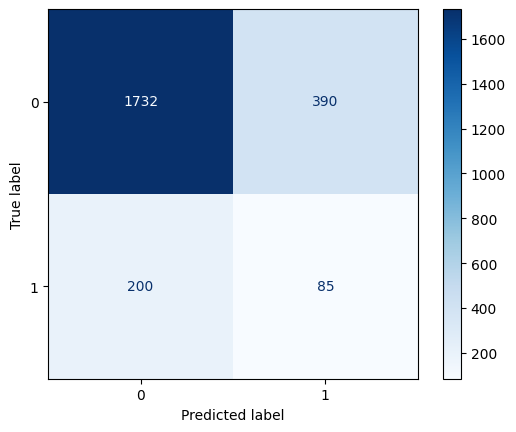

Accuracy: 0.7549
Precision: 0.1789
Recall: 0.2982
f1 score: 0.2237


In [72]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [73]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    random_state=1105
)

lr_model.fit(X_train_norm, y[train_mask])
y_pred = lr_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


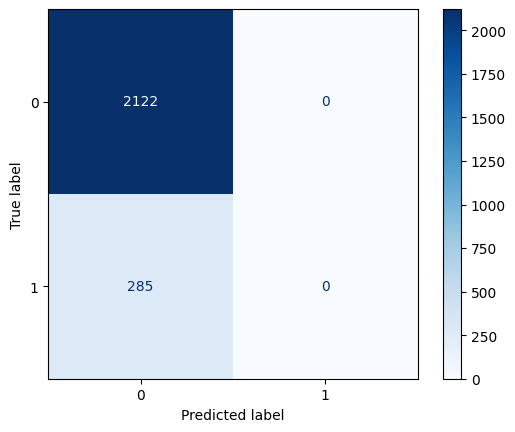

Accuracy: 0.8816
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [74]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [80]:
from sklearn.svm import LinearSVC

class_weight = {
    0: 1.0,
    1: 5.0
}
svc_model = LinearSVC(
    class_weight=class_weight,
    random_state=1105
)

svc_model.fit(X_train_norm, y[train_mask])
y_pred = svc_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


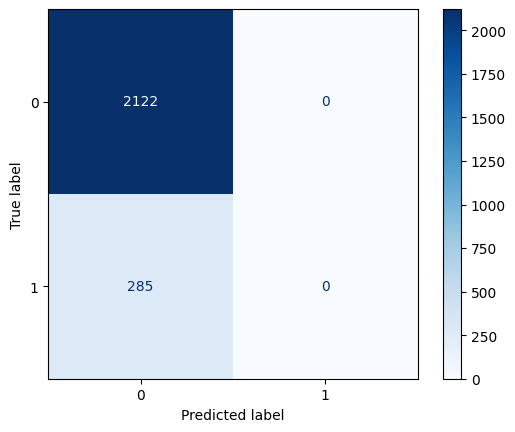

Accuracy: 0.8816
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [81]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [82]:
def count_parameters(params):
    num = sum(p.numel() for p in params if p.requires_grad)
    print(f"{num:,}")
    return num

In [97]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels * 2)
        self.lin3 = Linear(hidden_channels * 2, hidden_channels * 4)
        self.lin4 = Linear(hidden_channels * 4, hidden_channels * 8)
        self.lin5 = Linear(hidden_channels * 8, hidden_channels * 4)
        self.lin6 = Linear(hidden_channels * 4, hidden_channels * 2)
        self.lin7 = Linear(hidden_channels * 2, 1)
        self.norm1 = torch.nn.LayerNorm(hidden_channels)
        self.norm2 = torch.nn.LayerNorm(hidden_channels * 2)
        self.norm3 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm4 = torch.nn.LayerNorm(hidden_channels * 8)
        self.norm5 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm6 = torch.nn.LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin7(x)
        # x = self.log_softmax(x)
        # x = x.squeeze()
        return x
    
model = MLP(hidden_channels=64)
print(f"MLP model number of params: {count_parameters(model.parameters()):,}")

342,017
MLP model number of params: 342,017


In [98]:
weight = torch.Tensor([1.0, 2.5])
criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    X_tmp = data.x[data.train_mask]
    y_tmp = data.y[data.train_mask]
    preds = model(X_tmp).squeeze()  # Perform a single forward pass.
    loss = criterion(preds, y_tmp)  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_X_tmp = data.x[data.val_mask]
        v_y_tmp = data.y[data.val_mask]
        v_preds = model(v_X_tmp).squeeze()
        v_loss = criterion(v_preds, v_y_tmp)
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.8220 / Val_loss: 0.3830
Epoch: 002, Train_loss: 0.5523 / Val_loss: 0.3637
Epoch: 003, Train_loss: 0.4357 / Val_loss: 0.3735
Epoch: 004, Train_loss: 0.3921 / Val_loss: 0.3826
Epoch: 005, Train_loss: 0.3796 / Val_loss: 0.3890
Epoch: 006, Train_loss: 0.3743 / Val_loss: 0.3932
Epoch: 007, Train_loss: 0.3745 / Val_loss: 0.3956
Epoch: 008, Train_loss: 0.3802 / Val_loss: 0.3964
Epoch: 009, Train_loss: 0.3773 / Val_loss: 0.3958
Epoch: 010, Train_loss: 0.3817 / Val_loss: 0.3942
Epoch: 011, Train_loss: 0.3788 / Val_loss: 0.3917
Epoch: 012, Train_loss: 0.3791 / Val_loss: 0.3885
Epoch: 013, Train_loss: 0.3783 / Val_loss: 0.3847
Epoch: 014, Train_loss: 0.3788 / Val_loss: 0.3806
Epoch: 015, Train_loss: 0.3761 / Val_loss: 0.3764
Epoch: 016, Train_loss: 0.3750 / Val_loss: 0.3723
Epoch: 017, Train_loss: 0.3729 / Val_loss: 0.3685
Epoch: 018, Train_loss: 0.3697 / Val_loss: 0.3651
Epoch: 019, Train_loss: 0.3694 / Val_loss: 0.3623
Epoch: 020, Train_loss: 0.3668 / Val_loss: 0.3601


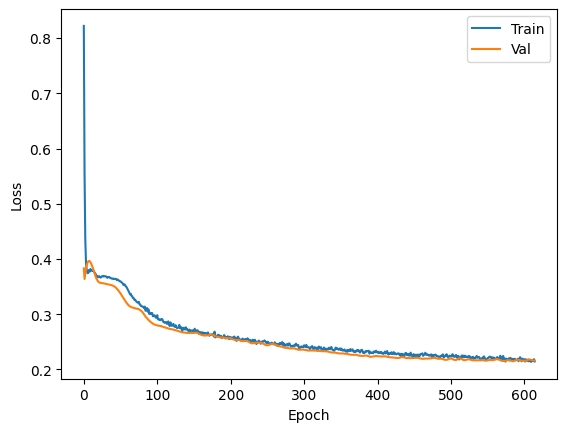

In [99]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

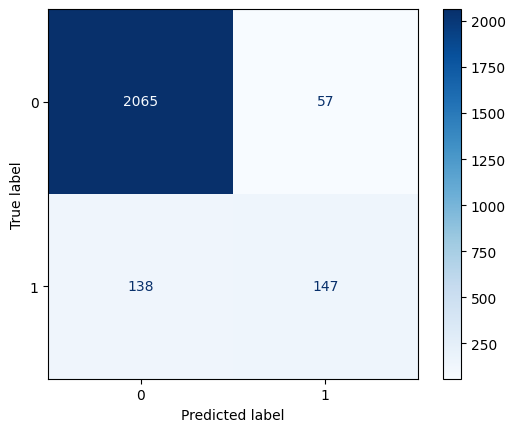

Accuracy: 0.9190
Precision: 0.7206
Recall: 0.5158
f1 score: 0.6012


In [100]:
model.eval()
X_tmp_test = data.x[data.test_mask]
y_tmp_test = data.y[data.test_mask]
with torch.no_grad():
    out = model(X_tmp_test)
# pred = out.argmax(dim=1)  # Use the class with highest probability.
pred = F.sigmoid(out).round()

cm = confusion_matrix(y_tmp_test, pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"Precision: {precision_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"Recall: {recall_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"f1 score: {f1_score(y_tmp_test.numpy(), pred.numpy()):.4f}")

In [101]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GCNConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GCNConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        x = x.squeeze()
        # x = self.log_softmax(x)
        return x

model = GCN(hidden_channels=64)
print(f"GCN model number of params: {count_parameters(model.parameters()):,}")

342,017
GCN model number of params: 342,017


In [102]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.4787 / Val_loss: 0.4742
Epoch: 002, Train_loss: 0.4515 / Val_loss: 0.4457
Epoch: 003, Train_loss: 0.4121 / Val_loss: 0.4185
Epoch: 004, Train_loss: 0.3879 / Val_loss: 0.3903
Epoch: 005, Train_loss: 0.4021 / Val_loss: 0.4026
Epoch: 006, Train_loss: 0.4017 / Val_loss: 0.4044
Epoch: 007, Train_loss: 0.3844 / Val_loss: 0.3850
Epoch: 008, Train_loss: 0.3808 / Val_loss: 0.3832
Epoch: 009, Train_loss: 0.3800 / Val_loss: 0.3795
Epoch: 010, Train_loss: 0.3811 / Val_loss: 0.3828
Epoch: 011, Train_loss: 0.3786 / Val_loss: 0.3766
Epoch: 012, Train_loss: 0.3720 / Val_loss: 0.3721
Epoch: 013, Train_loss: 0.3725 / Val_loss: 0.3704
Epoch: 014, Train_loss: 0.3751 / Val_loss: 0.3782
Epoch: 015, Train_loss: 0.3731 / Val_loss: 0.3774
Epoch: 016, Train_loss: 0.3698 / Val_loss: 0.3757
Epoch: 017, Train_loss: 0.3710 / Val_loss: 0.3652
Epoch: 018, Train_loss: 0.3665 / Val_loss: 0.3702
Epoch: 019, Train_loss: 0.3657 / Val_loss: 0.3781
Epoch: 020, Train_loss: 0.3674 / Val_loss: 0.3657


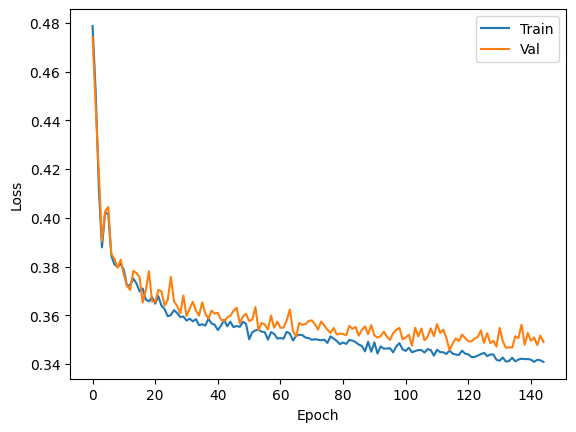

In [103]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [105]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = F.sigmoid(out).round()
# pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

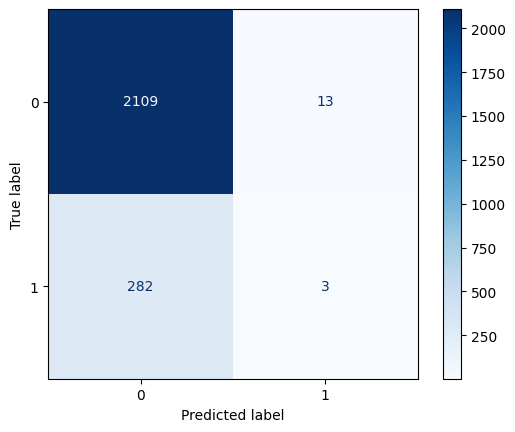

Accuracy: 0.8774
Precision: 0.1875
Recall: 0.0105
f1 score: 0.0199


In [106]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [107]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GATConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GATConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GATConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GATConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        # x = self.log_softmax(x)
        x = x.squeeze()
        return x


model = GAT(hidden_channels=64)
print(f"GAT model number of params: {count_parameters(model.parameters()):,}")

344,707
GAT model number of params: 344,707


In [108]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight) # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.5753 / Val_loss: 0.5776
Epoch: 002, Train_loss: 0.4279 / Val_loss: 0.4355
Epoch: 003, Train_loss: 0.4334 / Val_loss: 0.4297
Epoch: 004, Train_loss: 0.4436 / Val_loss: 0.4439
Epoch: 005, Train_loss: 0.4168 / Val_loss: 0.4198
Epoch: 006, Train_loss: 0.3918 / Val_loss: 0.3839
Epoch: 007, Train_loss: 0.3728 / Val_loss: 0.3740
Epoch: 008, Train_loss: 0.3601 / Val_loss: 0.3609
Epoch: 009, Train_loss: 0.3559 / Val_loss: 0.3627
Epoch: 010, Train_loss: 0.3544 / Val_loss: 0.3557
Epoch: 011, Train_loss: 0.3588 / Val_loss: 0.3596
Epoch: 012, Train_loss: 0.3601 / Val_loss: 0.3711
Epoch: 013, Train_loss: 0.3567 / Val_loss: 0.3630
Epoch: 014, Train_loss: 0.3480 / Val_loss: 0.3610
Epoch: 015, Train_loss: 0.3461 / Val_loss: 0.3490
Epoch: 016, Train_loss: 0.3429 / Val_loss: 0.3491
Epoch: 017, Train_loss: 0.3396 / Val_loss: 0.3508
Epoch: 018, Train_loss: 0.3393 / Val_loss: 0.3423
Epoch: 019, Train_loss: 0.3411 / Val_loss: 0.3480
Epoch: 020, Train_loss: 0.3418 / Val_loss: 0.3410


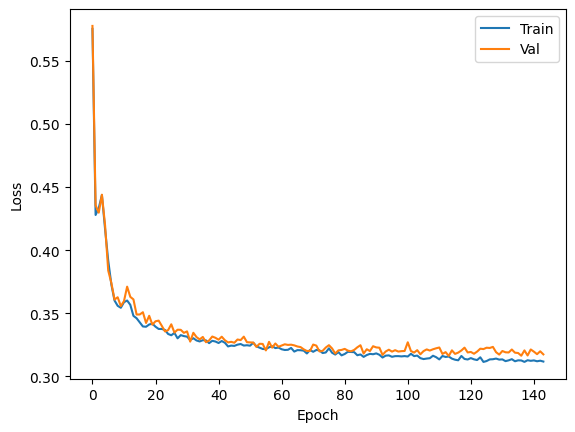

In [109]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

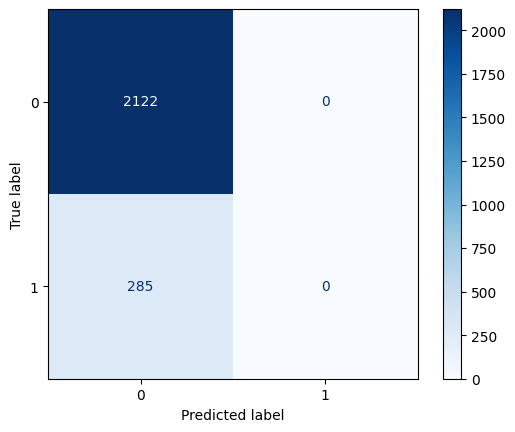

Accuracy: 0.8816
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [110]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = F.sigmoid(out).round()
# pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [111]:
sum(y) / len(y)

np.float64(0.11712273265598704)